# Descripción general
Tenemos los datos del ISIC de los cuales disponemos mas de 25 mil imágenes, pero al analizar los datos nos hemos encontrado con que las clases estan desbalanceadas, hay clases con 200 imagenes y otra con 12 mil imágenes.
# Clases a las que realizar el Data Augmetation
Aumentar los datos de Carcinoma de célula escamposa, Dermatofibroma y Lesión Bascular, ya que hay MUY pocas muestras. También se aumentaran los datos de Carcinoma de célula basal, Queratosis actínica y Queratosis Benigna, con menor incidencia.

In [2]:
import tensorflow as tf

from keras.models                import Sequential, Model
from keras.layers                import Dense, Input, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from keras.layers                import Conv2DTranspose, UpSampling2D, MaxPooling2D, Reshape, Activation, ReLU
from keras.preprocessing.image   import ImageDataGenerator
from keras.utils                 import to_categorical
from keras.optimizers            import SGD

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd

Using TensorFlow backend.


Visualizamos una imagen del dataset

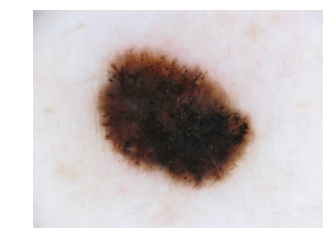

In [3]:
img1 = mpimg.imread("ISIC_2019_Training_Input/ISIC_0000013.jpg")
plt.axis("off")
plt.imshow(img1)
plt.show()

Obtenemos arrays con los distintos nombres de las imagenes de las que hay que hacer data augmetation. Cargamos el CSV donde se encuentra la codificación de las imagenes en One-hot.

In [15]:
df = pd.read_csv("ISIC_2019_Training_GroundTruth.csv")
df.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Los distintos **tipos** por orden de aparición son: 
* **MEL**: Melanoma
* **NV**: Nevus Melanocitico
* **BCC**: Célula Carcinoma Basal
* **AK**: Queratosis actínica
* **BKL**: Queratosis benigna 
* **DF**: Dermatofibroma
* **VASC**: Lesión Vascular
* **SCC**: Célula Carcinoma escamosa
* **UNK**: Desconocido

In [4]:
#Filtramos el DataFrame por el One-Hot y obtenemos una lista con los nombres de las imagenes que corresponden con esa etiqueta. 

DF = df[df["DF"] == 1.0]['image'].tolist() #200+ muestras
VASC = df[df["VASC"] == 1.0]['image'].tolist() #200+ muestras

SCC = df[df["SCC"] == 1.0]['image'].tolist() #600+ muestras
AK = df[df["AK"] == 1.0]['image'].tolist() #800+ muestras

BKL = df[df["BKL"] == 1.0]['image'].tolist() #2,6k+ muestras
BCC = df[df["BCC"] == 1.0]['image'].tolist() #3k+ muestras


# Pruebas para redimensionar una imagen
Buscamos la imagen de mayor resolución para poder redimensionar las imagenes y despues aumentarlos.

In [5]:
imgList = df['image'].tolist()

def mayorDim(imgList): 
    dimension = (0,0,0)
    mayorImg = ""
    count = 0
    for img in imgList:
        imagen = mpimg.imread("ISIC_2019_Training_Input/" + img + ".jpg")
        if dimension < imagen.shape:
            dimension = imagen.shape
            mayorImg = img
            
        #Barra de progreso
        count += 1
        if count%1000 == 0:
            print(count, end=" ")
            
    return mayorImg, dimension
        
mayorImg, dim = mayorDim(imgList)   
dim

1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 

(1024, 1024, 3)

La imágen mas grande es del 1024 x 1024, en 3 canales RGB. Para redimensionar las imágenes mas pequeñas usaremos la libreria PIL (Python Image Library) que permite procesar imágenes con facilidad.

In [6]:
dim = (1024,1024,3)

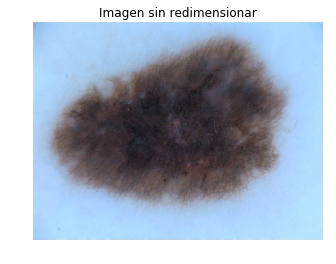

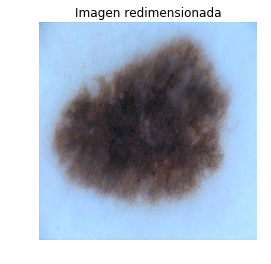

Tamaño de la imagen redimensionada: (1024, 1024, 3)
(1022, 3)
[[251 255 255]
 [230 234 243]
 [245 251 255]
 ..., 
 [238 255 255]
 [232 244 255]
 [252 255 244]]


In [7]:
from PIL import Image

img2 = Image.open("ISIC_2019_Training_Input/ISIC_0000000.jpg")
plt.axis("off")
plt.title("Imagen sin redimensionar")
plt.imshow(img2)
plt.show()

#Escalamos la imagen con antialisasing
img3 = img2.resize((1024, 1024), Image.ANTIALIAS)
plt.axis("off")
plt.title("Imagen redimensionada")
plt.imshow(img3)
plt.show()

array = np.array(img3)
print("Tamaño de la imagen redimensionada:", array.shape)

def resizeImg(img,dimToRe):
    if img.shape[1] < dimToRe[1]:
        #añadimos 0 al final de las filas
        print("h")
        

img4 = mpimg.imread("ISIC_2019_Training_Input/ISIC_0000000.jpg")
print(img4[0].shape) #Fila 1 todos los colores RGB
print(img4[:,0])

Como puede afectar a las texturas redimensionar la imagen vamos a añdir una franja negra cuando la dimensión sea mas pequeña

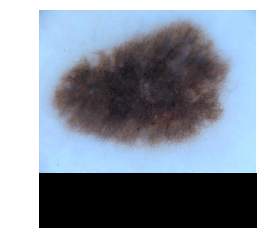

(1024, 1024, 3)

In [10]:
d = dim[0]

#Para cada img
width = d - img4[0].shape[0] #ancho
height = d - img4[:,0].shape[0] #altura

#Arrays que tenemos que concatenar a la imagen
widthArray = np.zeros((width,3))
heightArray = np.zeros((height,3))

#Creamos una imagen nueva negra y guardamos y sobrescribimos los datos de la img
img5 = np.zeros((1024,1024,3), dtype=int)

for i in range(img4[:,0].shape[0]): #lo hace 767 veces
    img5[i,:] = np.vstack((img4[i,:],widthArray))
    
plt.axis("off")
plt.imshow(img5)
plt.show()

img5.shape

# Guardar las nuevas imagenes redimensionadas
Vamos a guardar las imágenes redimensionadas remplazando las originales por las de la franja negra y si pertenecen a una de las clases donde hay pocos datos añadiremos las imagenes redimensionadas sin franjas negras al dataset. Por lo que habrá que añadirlas al CSV con su clase correspondiente.

In [11]:
def redimensionar(img4):
    width = d - img4[0].shape[0] #ancho
    height = d - img4[:,0].shape[0] #altura

    #Arrays que tenemos que concatenar a la imagen
    widthArray = np.zeros((width,3))
    heightArray = np.zeros((height,3))

    #Creamos una imagen nueva negra y guardamos y sobrescribimos los datos de la img
    img5 = np.zeros((1024,1024,3), dtype=int)

    for i in range(img4[:,0].shape[0]): #lo hace 767 veces
        img5[i,:] = np.vstack((img4[i,:],widthArray))
        
    return img5

In [70]:
imgList = df['image'].tolist()

def redimensionarPIL(nombreImg, tipo):
    img2 = Image.open("ISIC_2019_Training_Input - copia NO TOCAR/"+ nombreImg +".jpg")
    #img2 = Image.open("ISIC_2019_Training_Input/"+ nombreImg +".jpg")
    #Escalamos la imagen con antialisasing
    img3 = img2.resize((1024, 1024), Image.ANTIALIAS)
    img3.save("Prueba/"+ tipo+"-"+nombreImg+".jpg")

#MEL	NV	BCC	AK	BKL	DF	VASC	SCC	UNK
def tipoEscaso(nombreImg,array):
    #Pillamos solo las columnas que nos interesan para comprobar si tiene un 1
    #Ver el tipo de la imagen y comprobar si está vacio para añdir una nueva entrada en el csv
    if (not df.loc[df['image'] == nombreImg].loc[df['DF'] == 1].empty):
        redimensionarPIL(nombreImg,"DF")
        n=["DF-redim-"+nombreImg, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
        array = np.vstack((array,n))
        
    if (not df.loc[df['image'] == nombreImg].loc[df['VASC'] == 1].empty):
        redimensionarPIL(nombreImg,"VASC")
        n=["VASC-redim-"+nombreImg, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
        array = np.vstack((array,n))
        
    if (not df.loc[df['image'] == nombreImg].loc[df['SCC'] == 1].empty):
        redimensionarPIL(nombreImg,"SCC")
        n=["SCC-redim-"+nombreImg, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
        array = np.vstack((array,n))
        
    if (not df.loc[df['image'] == nombreImg].loc[df['AK'] == 1].empty):
        redimensionarPIL(nombreImg,"AK")
        n=["AK-redim-"+nombreImg, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        array = np.vstack((array,n))
    return array



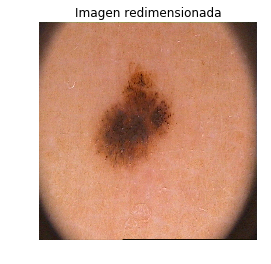

In [69]:
redimensionarPIL(imgList[300],"AK")

In [71]:
import os
#Vemos donde vamos a guardar la imagen
print(os.getcwd())
print(os.listdir())

#Como guardar una imagen con la libreria Pillow desde una imagen con formato np.array
image = Image.fromarray(img5.astype('uint8'), 'RGB')
image.save('Prueba/image.png')


F:\Melanoma IA curso
['.ipynb_checkpoints', 'Clasificación de datos ISIC.ipynb', 'Data Augmentation ISIC.ipynb', 'image.png', 'ISIC_2019_Training_GroundTruth.csv', 'ISIC_2019_Training_Input', 'ISIC_2019_Training_Input - copia NO TOCAR', 'ISIC_2019_Training_Metadata.csv', 'Prueba']


In [56]:
imgList = df['image'].tolist()
dim = (1024,1024,3)
count = 0
array = ["borrar", 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

for img in imgList:
    #Barra de progreso
    count += 1
    if count%1000 == 0:
        print(count, end=" ")
        
    #Redimensionado de las imagenes
    imagen = mpimg.imread("ISIC_2019_Training_Input/" + img + ".jpg")
    if dim > imagen.shape: #Es mas pequeña hay que redimensionar
        tipoEscaso(img,array) #Si es tipo escaso aumentamos datos con una redimensión
        #guardar = redimensionar(imagen) #Redimensionamos con las franjas negras 
        #Guardamos la imagen con el mismo nombre
        #image = Image.fromarray(guardar.astype('uint8'), 'RGB')
        #image.save("ISIC_2019_Training_Input/"+img+".jpg")

1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 

**OJO: Las imagenes redimensionadas sin fraja negra no han salido.**

Juntamos el dataframe con las nuevas imágenes junto con el dataframe del resto de imágenes

In [54]:
#Como concatenar dos DataFrames
nombreImg = "kk"
n=["AK-"+nombreImg, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
n2=["SCC-"+nombreImg, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]

n12 = np.vstack((n,n2))
t = pd.DataFrame(n12, columns = ["imagen","MEL","NV","BCC","AK","BKL","DF","VASC","SCC","UNK"])
t

,imagen,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,AK-kk,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,SCC-kk,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
#borramos la fila de array
#añadimos esas imagenes al dataset
t = pd.DataFrame(n12, columns = ["imagen","MEL","NV","BCC","AK","BKL","DF","VASC","SCC","UNK"])
#Las guardamos en el CSV

## Organizar las imagenes por carpetas 

## Aumentar los datos

In [ ]:
#Creamos datos aumentados
#datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, rotation_range=40)
#X_data_directory = datagen.flow_from_directory("ISIC_2019_Training_Input" ,target_size=(150,150), batch_size=32, class_mode='binary')

#datagen2 = ImageDataGenerator(rescale = 1./255)
#Y_data_directory = datagen2.flow_from_directory("cats_and_dogs_filtered/validation" ,target_size=(150,150), batch_size=32, class_mode='binary')